In [124]:
#https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [125]:
tf.random.set_seed(1234)

In [126]:
# Import data using datetime and set index to datetime
df = pd.read_csv(r'C:\Users\91783\Desktop\DataSet\1_Bhiwadi\Book_1_PM.csv',
                                parse_dates=['Date'],
                                index_col=['Date'])

df.head()

,PM2.5
Date,
2021-01-01,228.53
2021-02-01,222.37
2021-03-01,128.14
2021-04-01,68.44
2021-05-01,62.51


In [127]:
df

,PM2.5
Date,
2021-01-01,228.53
2021-02-01,222.37
2021-03-01,128.14
2021-04-01,68.44
2021-05-01,62.51
...,...
2021-12-27,92.11
2021-12-28,124.25
2021-12-29,105.15


In [128]:
# Split train data and test data
#train_size = int(len(df)*0.8)
train_size = 300
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [129]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [130]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (270, 30, 1)
y_train.shape:  (270, 1)
X_test.shape:  (35, 30, 1)
y_test.shape:  (35, 1)


In [131]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [132]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
14/14 [==============================] - 3s 54ms/step - loss: 0.0706 - val_loss: 0.0213
Epoch 2/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0207 - val_loss: 0.0170
Epoch 3/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0253 - val_loss: 0.0165
Epoch 4/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0199 - val_loss: 0.0162
Epoch 5/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0216 - val_loss: 0.0151
Epoch 6/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0214 - val_loss: 0.0155
Epoch 7/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0207 - val_loss: 0.0152
Epoch 8/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0205 - val_loss: 0.0150
Epoch 9/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0211 - val_loss: 0.0150
Epoch 10/100
14/14 [==============================] - 0s 18ms/step - loss: 0.0209 - val_loss: 0.0148

In [133]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

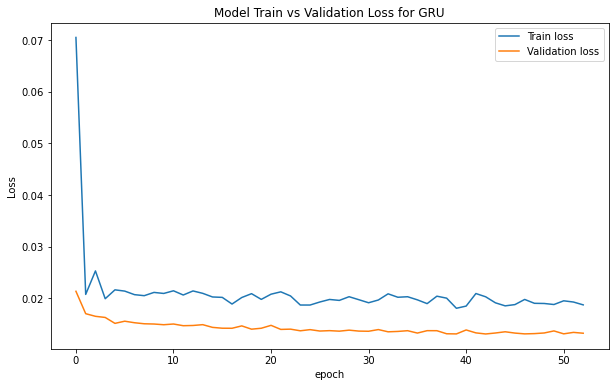

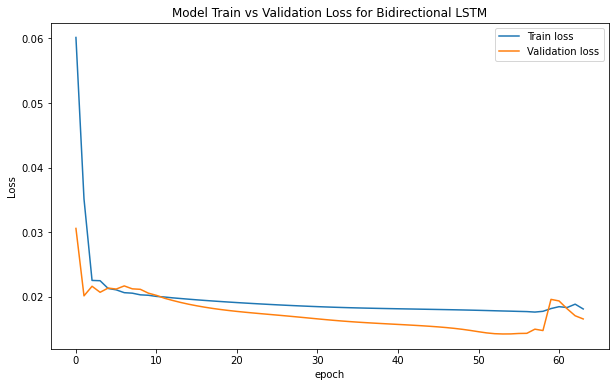

In [134]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss(history_gru, 'GRU')
plot_loss(history_bilstm, 'Bidirectional LSTM')

2/2 [==============================] - 1s 7ms/step


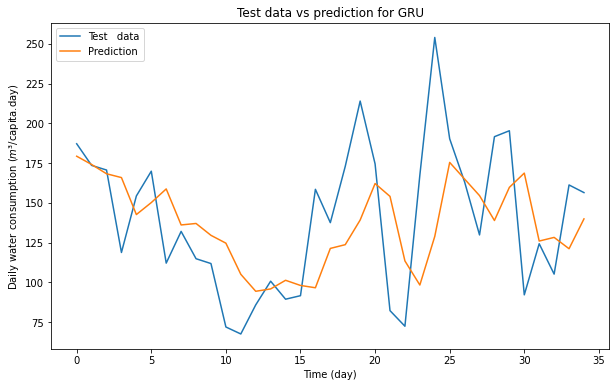

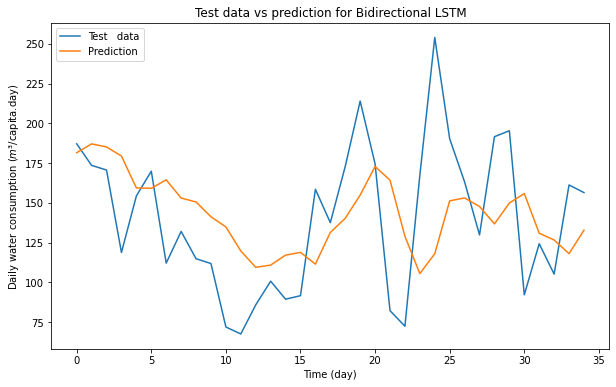

In [135]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m³$/capita.day)')
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [136]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print("")
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

GRU:
Mean Absolute Error: 31.7480
Root Mean Square Error: 42.4195

Bidirectiona LSTM:
Mean Absolute Error: 36.0406
Root Mean Square Error: 45.1987



In [137]:
prediction_gru

array([[179.28528 ],
       [174.09163 ],
       [168.25368 ],
       [165.85406 ],
       [142.60164 ],
       [150.13663 ],
       [158.71786 ],
       [136.06575 ],
       [136.9948  ],
       [129.5341  ],
       [124.60826 ],
       [105.041534],
       [ 94.34961 ],
       [ 95.82907 ],
       [101.26499 ],
       [ 98.01717 ],
       [ 96.565834],
       [121.30639 ],
       [123.65956 ],
       [139.16727 ],
       [162.10408 ],
       [154.02286 ],
       [113.44039 ],
       [ 98.296074],
       [128.85072 ],
       [175.38548 ],
       [164.91672 ],
       [154.52069 ],
       [138.86581 ],
       [159.69266 ],
       [168.67406 ],
       [125.938835],
       [128.23506 ],
       [121.11085 ],
       [139.87741 ]], dtype=float32)

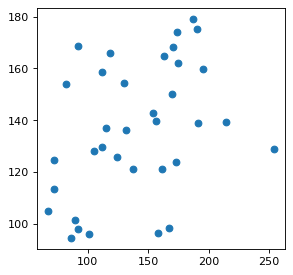

In [138]:
#for GRU
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4),dpi=80)
plt.scatter(y_test,prediction_gru)
plt.show()

<AxesSubplot:>

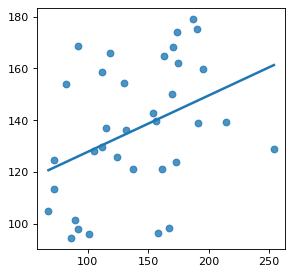

In [139]:
import seaborn as sb
plt.figure(figsize=(4,4),dpi=80)
sb.regplot(y_test,prediction_gru,ci=None)

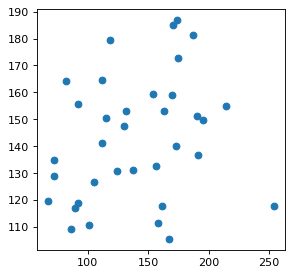

In [140]:
#for BIDIRECTIONAL LSTM
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4),dpi=80)
plt.scatter(y_test,prediction_bilstm)
plt.show()

<AxesSubplot:>

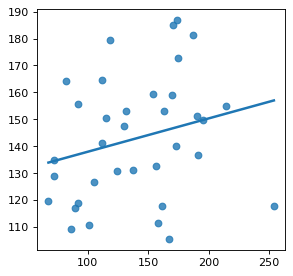

In [141]:
import seaborn as sb
plt.figure(figsize=(4,4),dpi=80)
sb.regplot(y_test,prediction_bilstm,ci=None)